# Setting up the array of inputs 

In [3]:
import csv
import itertools

# Define your ranges here
loss_range  = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
ndbp_range  = [0,1,2,3,4]                   
ng_range    = [0,1,2,3,4,5,6,7,8,9,10]             
seeds       = [42,69]        

# Output file
outfile = "arrayInputs.csv"

# Cartesian product of all ranges
rows = itertools.product(loss_range, ndbp_range, ng_range, seeds)

# Write CSV
with open(outfile, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["LOSS_INDEX", "NDBP_INDEX", "NG_INDEX", "SEED"])
    for row in rows:
        writer.writerow(row)

print(f"Wrote CSV with all combinations → {outfile}")


Wrote CSV with all combinations → arrayInputs.csv


In [ ]:
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath("/Users/dominic/Desktop/optGME"))
from optomization import W1
from optomization import comp_backscatter
import legume

In [54]:
kpoints = np.linspace(np.pi*.5,np.pi,200)
gmeParams = {'verbose':True,'numeig':15,'compute_im':False,'gmode_inds':[0],'kpoints':np.vstack([kpoints,[0]*len(kpoints)])}
phcParams = {"Ny":7,"dslab":270/455,"eps_slab":3.13}
backscatterParams = {'a':455,'sig':3,'lp':40,'phidiv':45,'zdiv':10}

phc = W1(NyChange=0,**phcParams)
gme = legume.GuidedModeExp(phc,3)
gme.run(**gmeParams)

    

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 321 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 9.095    │ │██████--------------│   35% │
│ Inverse matrix of Fourier-space permittivity               │ 0.020    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver            │ 8.899    │ │██████--------------│   34% │
│ Creating GME matrix                                        │ 7.800    │ │█████---------------│   30% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 200 k-points   │ 26.031   │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

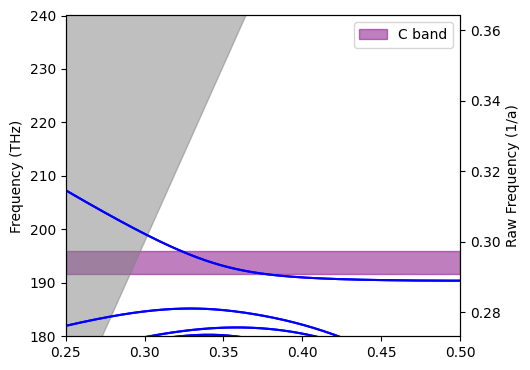

In [55]:
fconv = 299792458/455/1e-9/1e12
c_band_max = 195.9
c_band_min = 191.56

fig, ax1 = plt.subplots(figsize=(5.4, 3.8))

# Plot with frequency conversion on the left axis
ax1.plot(kpoints/np.pi/2, gme.freqs*fconv, color='b')
ax1.fill_between(kpoints/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5,label='C band')
ax1.fill_between(kpoints/np.pi/2, kpoints*fconv/np.pi/2, np.max(kpoints)*fconv/np.pi/2, color='gray', alpha=.5)
ax1.set_ylim(180, 240)
ax1.set_xlim(.25, 0.5)
ax1.set_ylabel('Frequency (THz)')

# Create a second y-axis without frequency conversion
ax2 = ax1.twinx()
ax2.plot(kpoints/np.pi/2, gme.freqs, color='b')
ax2.set_ylabel('Raw Frequency (1/a)')
# Match x-limits
ax2.set_ylim(ax1.get_ylim()[0]/fconv, ax1.get_ylim()[1]/fconv)
ax1.legend()
fig.tight_layout()
plt.show()

41

In [85]:
l0 = 1550e-9
a= 455e-9

mink = np.argmin(np.abs(gme.freqs[:,14]-gme.kpoints[0,:]/(2*np.pi)))

NDBPs = np.linspace(.2,.5,5,endpoint=True)
Delta_k = NDBPs*a/l0

krange = np.ceil(Delta_k/np.diff(gme.kpoints[0,:]/2/np.pi)[0])

buffers = (len(kpoints)-mink-krange)//2

startEnds = np.array([[mink+b,len(kpoints)-b] for b in buffers],dtype=int)
kpoints = np.array([np.linspace(startEnds[i,0],startEnds[i,1],8,dtype=int,endpoint=True) for i in range(len(startEnds))])

In [77]:
print(startEnds[:,1]-startEnds[:,0])
print(krange)

[ 47  65  83 101 117]
[ 47.  65.  82. 100. 117.]


In [86]:
print(kpoints)

[[ 97 103 110 117 123 130 137 144]
 [ 88  97 106 115 125 134 143 153]
 [ 79  90 102 114 126 138 150 162]
 [ 70  84  98 113 127 142 156 171]
 [ 62  78  95 112 128 145 162 179]]


In [90]:
ksbefore = np.array([[start//3,2*start//3] for start in startEnds[:,0]])
print(ksbefore)
ksafter = np.array([[b//3+end,2*b//3+end] for end,b in zip(startEnds[:,1],buffers)],dtype=int)
print(ksafter)


[[32 64]
 [29 58]
 [26 52]
 [23 46]
 [20 41]]
[[162 181]
 [168 184]
 [174 187]
 [180 190]
 [186 193]]
